<a href="https://colab.research.google.com/github/oreilly-japan/ml-at-work/blob/master/chap11/02_bandit_algorithm_compare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![表紙](https://www.oreilly.co.jp/books/images/picture978-4-87311-947-2.gif)

이 노트북은 한빛미디어에서 발생한 [<<머신러닝 실무 프로젝트 2판>>]()의 샘플 코드입니다. 코드 설명은 책 내용을 확인합니다. 또한, 이 코드를 실행한 결과에 대해 한빛미디어 및 옮긴이는 일체의 책임을 지지 않습니다.

## 11.7 다양한 슬롯머신 알고리즘 비교

In [ ]:
import numpy as np
import scipy
import scipy.stats
import matplotlib.pyplot as plt

In [ ]:
def random_strategy(success_counts, fail_counts):
    return np.random.choice(len(success_counts))

def baysian_ucb_strategy(success_counts, fail_counts, q=0.95):
    score = scipy.stats.beta.ppf(q, success_counts + 1, fail_counts + 1)
    return np.argmax(score)

def ucb1_strategy(success_counts, fail_counts):
    mean = (success_counts) / (success_counts + fail_counts)
    total_count = np.sum(success_counts + fail_counts)
    ucb = (
            2.0 * np.log(total_count) / (success_counts + fail_counts)
          ) ** 0.5
    score = mean + ucb
    return np.argmax(score)

def softmax_strategy(success_counts, fail_counts, t=0.05):
    mean = (success_counts) / (success_counts + fail_counts)
    select_rate = np.exp(mean / t)/ np.sum(np.exp(mean / t))
    return np.random.choice(len(select_rate), p=select_rate)

def softmax_annealing_strategy(success_counts, fail_counts, initial_t=0.1, k=100.0):
    mean = (success_counts) / (success_counts + fail_counts)
    t = initial_t / np.log(k * np.sum(success_counts + fail_counts) + 2)
    select_rate = np.exp(mean / t) / np.sum(np.exp(mean / t))
    return np.random.choice(len(select_rate), p=select_rate)

def thompson_sampling_strategy(success_counts, fail_counts):
    score = scipy.stats.beta.rvs(success_counts + 1, fail_counts + 1)
    return np.argmax(score)

In [ ]:
actual_cvr = [0.12, 0.11, 0.10]
bandit_round = 10000
#random_seed = 1234567
random_seed = 1234

strategy_list = [
    ("Random", random_strategy),
    ("Baysian_UCB", baysian_ucb_strategy),
    ("UCB1", ucb1_strategy),
    ("Softmax", softmax_strategy),
    ("Softmax_annealing", softmax_annealing_strategy),
    ("Thompson_sampling", thompson_sampling_strategy)
]

scores = []
arm1_select_rates = []

for name, select_arm_method in strategy_list:
    # random seed를 초기화한다
    # scipy는 numpy의 난수를 사용하므로 scipy도 동시에 초기화할 수 있다
    np.random.seed(random_seed)

    success_counts = np.array([0.0, 0.0, 0.0])
    fail_counts = np.array([0.0, 0.0, 0.0])
    
    scores.append([])
    arm1_select_rates.append([])
    
    for i in range(bandit_round):
        if i < 1000:  # 최초 1,000 라운드는 무작위로 송신한다
            selected_arm = random_strategy(success_counts, fail_counts)
        else:
            selected_arm = select_arm_method(success_counts, fail_counts)

        # 선택한 팔의 컨버전 여부 판덩
        if np.random.rand() < actual_cvr[selected_arm]:
            success_counts[selected_arm] += 1
        else:
            fail_counts[selected_arm] += 1
        
        score = np.sum(success_counts) / np.sum(success_counts + fail_counts)
        scores[-1].append(score)
        
        arm1_select_rate = (success_counts[0] + fail_counts[0]) / np.sum(success_counts + fail_counts)
        arm1_select_rates[-1].append(arm1_select_rate)

Random 0.1115
Baysian_UCB 0.116
UCB1 0.1144
Softmax 0.1164
Softmax_annealing 0.1198
Thompson_sampling 0.1162


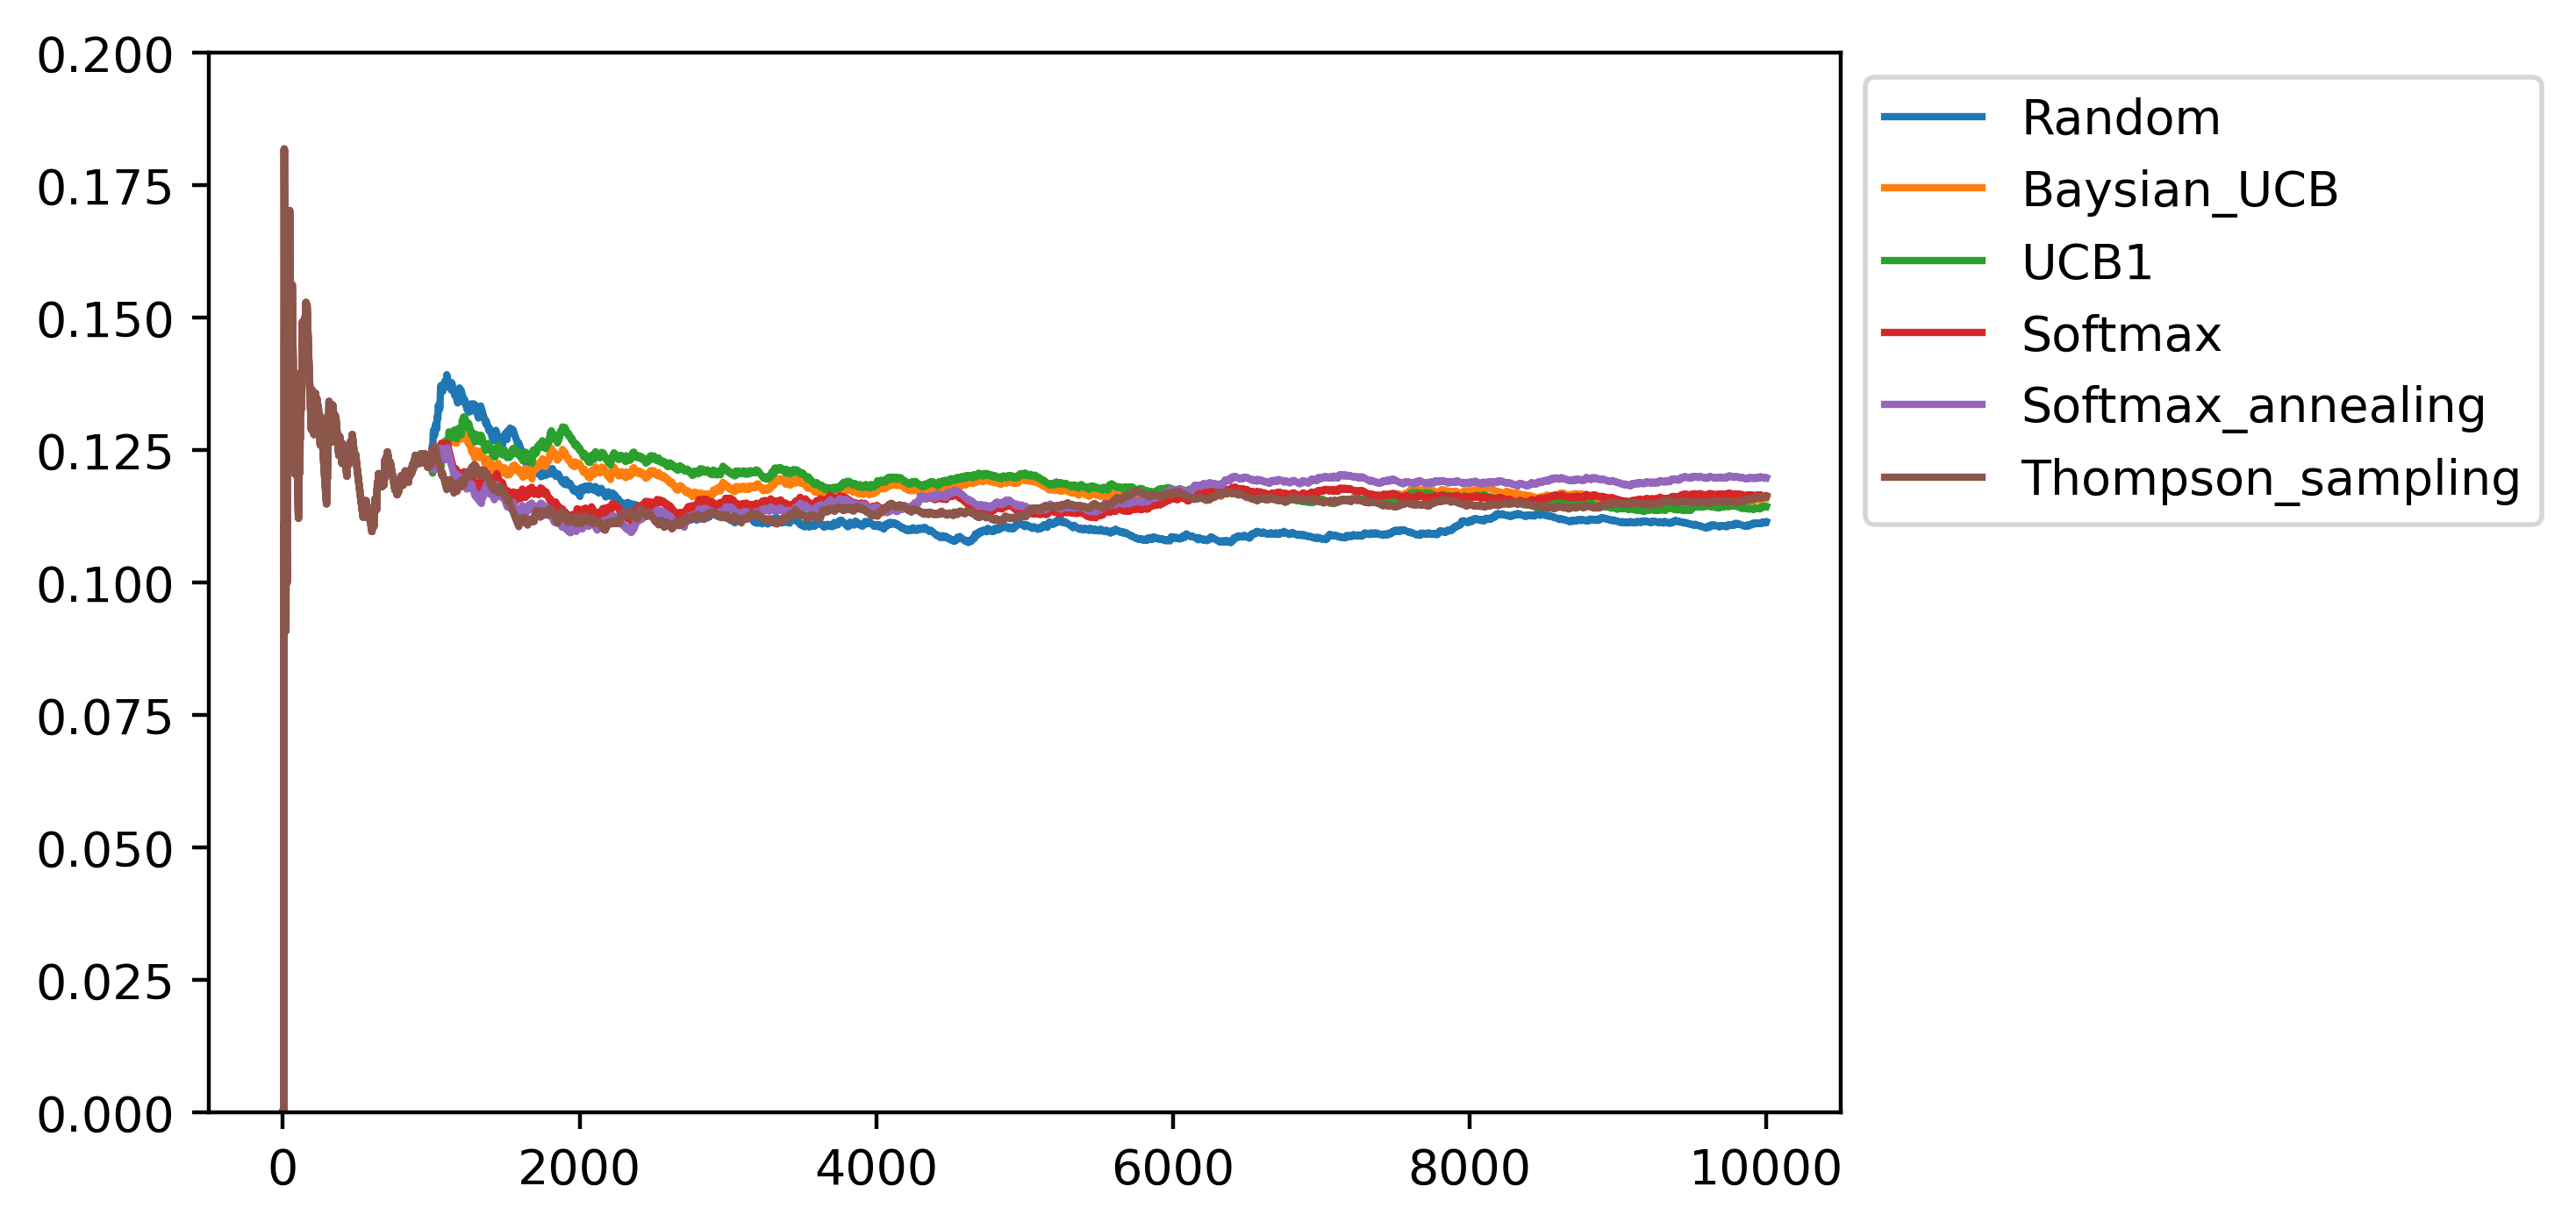

In [ ]:
plt.figure(dpi=400)
for i in range(len(strategy_list)):
    algorithm_name = strategy_list[i][0] 
    print(algorithm_name, scores[i][-1])
    plt.plot(scores[i], label=algorithm_name)
    plt.ylim(0.0, 0.2)

plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
plt.show()    

Random 0.3335
Baysian_UCB 0.4422
UCB1 0.3881
Softmax 0.3459
Softmax_annealing 0.5624
Thompson_sampling 0.6684


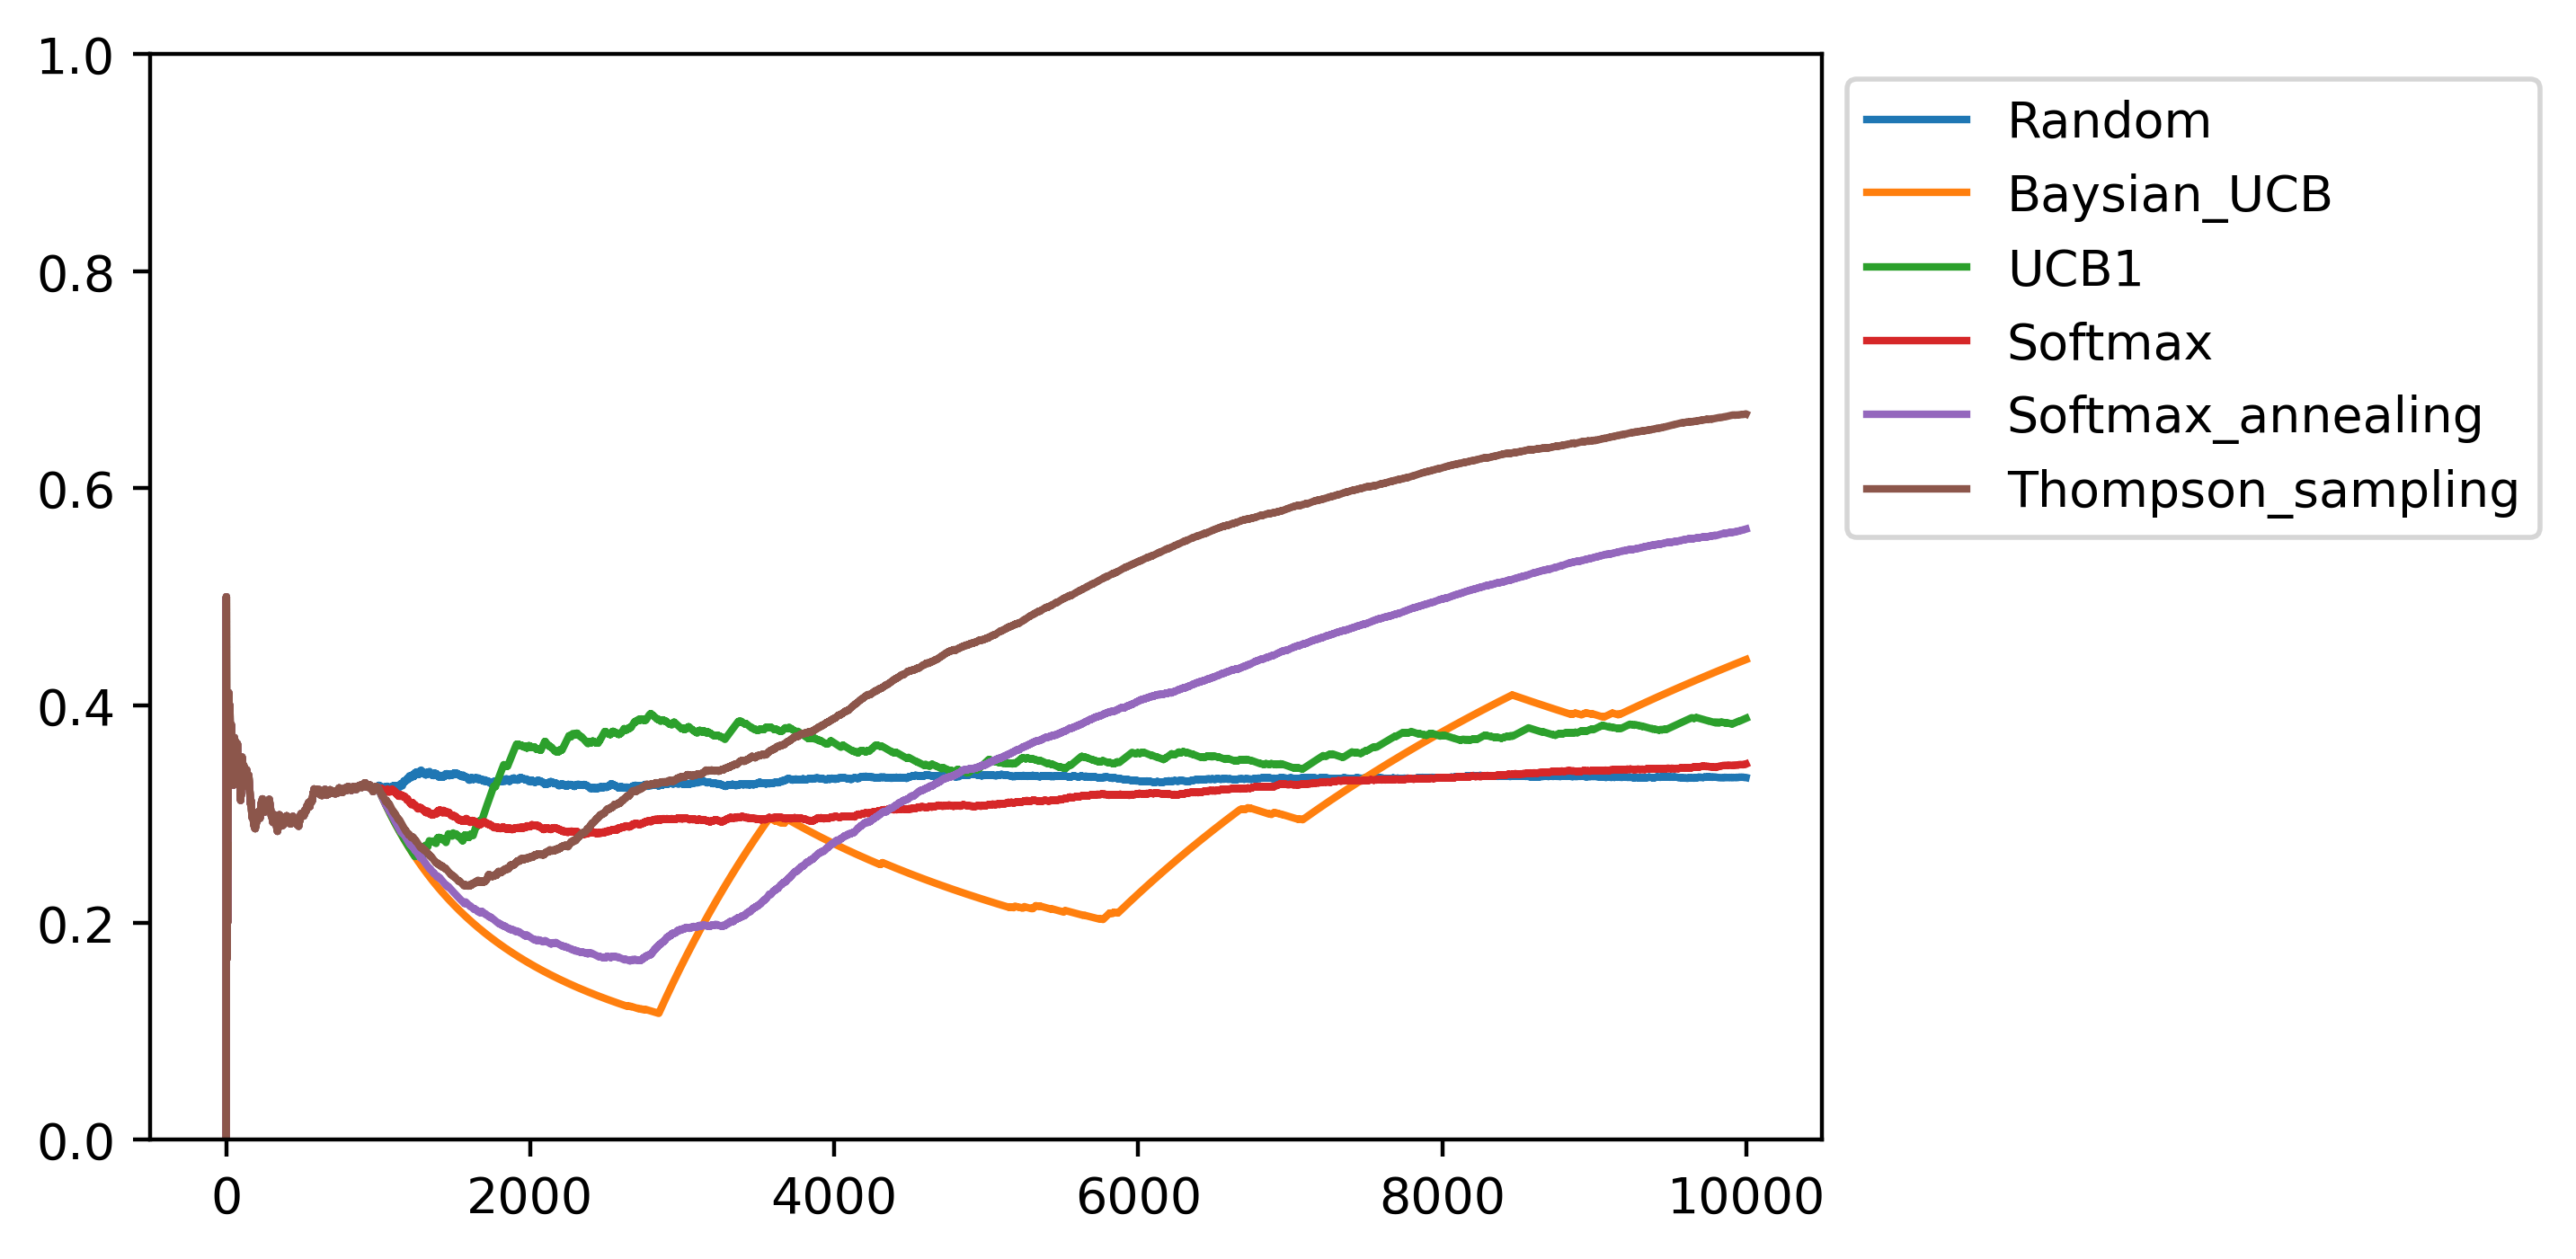

In [ ]:
plt.figure(dpi=400)
for i in range(len(strategy_list)):
    algorithm_name = strategy_list[i][0] 
    print(algorithm_name, arm1_select_rates[i][-1])
    plt.plot(arm1_select_rates[i], label=algorithm_name)
    plt.ylim(0, 1)

plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
plt.show()